# eQTL Input 

In [175]:
import copy
import cPickle
import glob
import gzip
import os
import random
import shutil
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peer
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import vcf as pyvcf

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

random.seed(20150605)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [179]:
sns.set_context('notebook')

In [ ]:
outdir = os.path.join(ciepy.root, 'output',
                      'eqtl_input')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'eqtl_input')
cpy.makedir(private_outdir)

In [ ]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'array_metadata.tsv')
array_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta = rna_meta[rna_meta.in_eqtl]
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

#fn = os.path.join(ciepy.root, 'private_data', 'TableOf280_PedigreeWithUUIDS_forPhasing_V2.xlsx')
#pedigree = pd.read_excel(fn)
#pedigree.index = pedigree['ID']

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

#fn = os.path.join(ciepy.root, 'output', 'input_data', 'gene_counts.tsv')
#gene_counts = pd.read_table(fn, index_col=0)
#fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_expected_counts.tsv')
#ecounts = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
tpm = tpm[rna_meta.index]
log_tpm = np.log10(tpm + 1)
#fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_fpkm.tsv')
#fpkm = pd.read_table(fn, index_col=0)
#log_fpkm = np.log10(fpkm + 1)

In [ ]:
def transform_standard_normal(df):
    gc_ranks = df.rank(axis=1)
    gc_ranks = gc_ranks / (gc_ranks.shape[1] + 1)
    std_norm = stats.norm.ppf(gc_ranks)
    std_norm = pd.DataFrame(std_norm, index=gc_ranks.index, 
                            columns=gc_ranks.columns)
    return std_norm

## Kinship Matrix

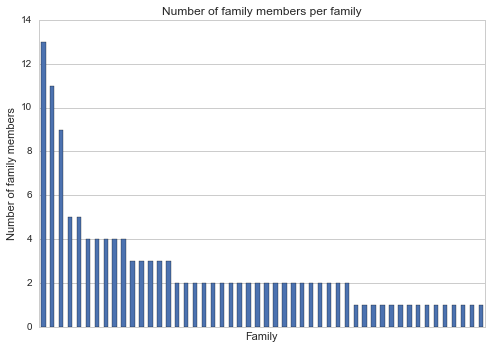

In [117]:
with sns.axes_style('whitegrid'):
    subject_meta.family_id.value_counts().plot(kind='bar')
    plt.ylabel('Number of family members')
    plt.title('Number of family members per family')
    plt.xticks([])
    plt.xlabel('Family')
    plt.savefig(os.path.join(outdir, 'num_per_family.pdf'))

In [ ]:
wgs_vcf = os.path.join(ciepy.root, 'private_data', 'wgs', 'biallelic_snvs_pruned_conv.vcf.gz')

wgs_kmatrix = os.path.join(outdir, 'wgs.kin')
if not os.path.exists(wgs_kmatrix):
    c = ('{} make-kin --vcf {} --min-maf 0.01 --min-callrate 0.95 '
         '--out {} --run 10'.format(cpy.epacts, wgs_vcf, wgs_kmatrix))
    subprocess.check_call(c, shell=True)
    
wgs_kdump = os.path.join(outdir, 'wgs.kindump')
if not os.path.exists(wgs_kdump):
    c = ('{}/pEmmax kin-util --kinf {} --outf {} --dump'.format(
        os.path.split(cpy.epacts)[0], wgs_kmatrix, os.path.splitext(wgs_kdump)[0]))
    subprocess.check_call(c, shell=True)
    
wgskmatrix = pd.read_table(wgs_kdump)

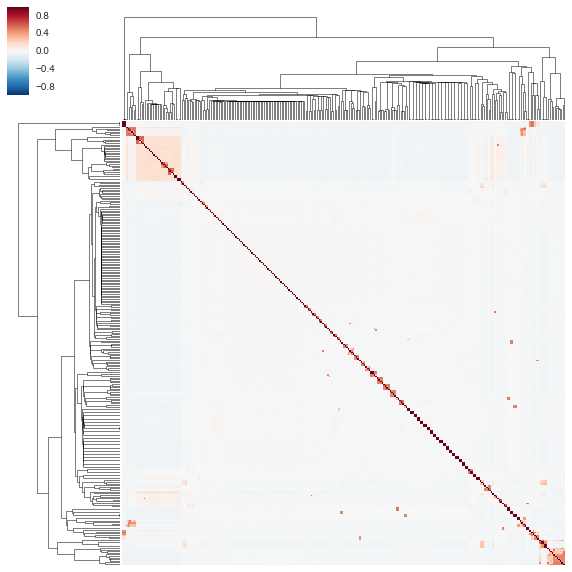

In [119]:
sns.clustermap(wgskmatrix, xticklabels=False, yticklabels=False, linewidths=0);

## EMMAX Files

EMMAX needs the following files:
* `.phe` : Phenotype file. First column individual ID, second column phenotype value. I'll create
this on the fly for each gene.
* `.cov` : Covariate file. First column individual ID, subsequent columns are covariates. It doesn't 
seem to be necessary to include an intercept.
* `.ind` : VCF key. First column individual ID, second column is the one-based position of this key 
in the VCF header. I think this should be ordered such that the second column always increases, but 
you don't have to use every sample in the vcf. Currently, I use the ind file to subset the samples 
in the VCF file, so the order of the samples in the VCF doesn't matter.

In [ ]:
os.path.join(outdir, 'emmax.ind')
if not os.path.exists(fn):
    fn = os.path.join(ciepy.root, 'private_data', 'wgs', 'biallelic_snvs.vcf.gz')
    v = pyvcf.Reader(open(fn), compressed=True)
    r = v.next()
    samples = [s.sample for s in r]

    se = pd.Series(range(1, len(samples) + 1), index=samples)
    se = se[rna_meta.wgs_id]
    se.sort()
    se.to_csv(fn, sep='\t', header=False)

In [ ]:
fn = os.path.join(outdir, 'emmax_full.cov')
if not os.path.exists(fn):
    cov = pd.get_dummies(data=rna_meta, columns=['sequence_id'])
    cov = cov.merge(subject_meta, left_on='subject_id', right_index=True)
    cov = cov[['sex', 'age', 'sequence_id_6', 'sequence_id_7']]
    cov['sex'] = cov.sex.apply(lambda x: {'M':1, 'F':2}[x])
    cov = cov.astype(int)
    cov.index = rna_meta.wgs_id
    cov = cov.ix[se.index]
    cov.to_csv(fn, sep='\t', header=False)
    cov['sex'].to_csv(os.path.join(outdir, 'emmax_sex_only.cov'), sep='\t', header=False)

## Gene Expression

I'll make normalized counts from DESeq and VST counts. I'll also get counts from RSEM.

### Naive Counts: Library Normalized and VST

### RSEM

For now, I'm going to use the filtering done on the naive counts to filter
the other gene expression estimates as well. This seems reasonable since the
actual number of reads is tied heavily to my ability to predict expression.
I can come back and filter differently later if I want to.

#### Expected counts

#### TPM

I think I want to update that filter below to be

    tpm_f = log_tpm[(log_tpm > np.log10(2)).sum(axis=1) >= 10]
    
or something. I think I chose the wrong cutoff based on the GTEx paper. They
might have said a gene was expressed if they saw it in two people but
they might have used a different cutoff (10?) for testing for eQTLs.

In [ ]:
tpm_f = log_tpm[(log_tpm > np.log10(2)).sum(axis=1) >= 2]
tpm_f = (tpm_f.T - tpm_f.mean(axis=1)).T
tpm_f.to_csv(os.path.join(outdir, 'tpm_log_filtered.tsv'), sep='\t')
# I'll also write a file with the WGS ID for each sample
# for use with EMMAX.
tpm_f.columns = rna_meta.ix[tpm_f.columns, 'wgs_id']
tpm_f = tpm_f[se.index]
tpm_f.to_csv(os.path.join(outdir, 'tpm_log_filtered_phe.tsv'), sep='\t')
# Standard normal transformed.
tpm_f_std_norm = transform_standard_normal(tpm_f)
tpm_f_std_norm.to_csv(
    os.path.join(outdir, 'tpm_log_filtered_phe_std_norm.tsv'), sep='\t')

In [253]:
fns = [os.path.join(outdir, 'peer_20_factors.tsv'),
       os.path.join(outdir, 'peer_20_weights.tsv'),
       os.path.join(outdir, 'peer_20_precision.tsv'),
       os.path.join(outdir, 'peer_20_residuals.tsv')]
if sum([os.path.exists(x) for x in fns]) != len(fns):
    model = peer.PEER()
    model.setPhenoMean(tpm_f_std_norm)
    model.setNk(20)
    model.update()

    factors = pd.DataFrame(model.getX(), index=tpm_f_std_norm.index)
    factors.to_csv(os.path.join(outdir, 'peer_20_factors.tsv'), sep='\t',
                   header=False)
    weights = pd.DataFrame(model.getW(), index=tpm_f_std_norm.columns)
    weights.to_csv(os.path.join(outdir, 'peer_20_weights.tsv'), sep='\t',
                   header=False)
    precision = pd.Series(model.getAlpha()[:, 0])
    precision.to_csv(os.path.join(outdir, 'peer_20_precision.tsv'), 
                     sep='\t', index=False, header=False)
    residuals = pd.DataFrame(model.getResiduals(), index=tpm_f_std_norm.index,
                             columns=tpm_f_std_norm.columns)
    residuals.to_csv(os.path.join(outdir, 'peer_20_residuals.tsv'),
                     sep='\t')
else:
    factors = pd.read_table(os.path.join(outdir, 'peer_20_factors.tsv'),
                            index_col=0, header=None)
    weights = pd.read_table(os.path.join(outdir, 'peer_20_weights.tsv'),
                            index_col=0, header=None)
    precision = pd.read_table(os.path.join(outdir, 'peer_20_precision.tsv'),
                              header=None, squeeze=True)
    residuals = pd.read_table(os.path.join(outdir, 'peer_20_residuals.tsv'),
                              index_col=0)

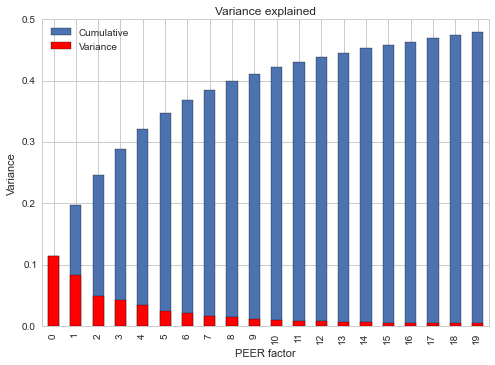

In [244]:
with sns.axes_style('whitegrid'):
    pd.Series(1 / precision).cumsum().plot(label='Cumulative', kind='bar')
    (1 / precision).plot(kind='bar', label='Variance', color='red')
    plt.title('Variance explained')
    plt.ylabel('Variance')
    plt.xlabel('PEER factor')
    plt.legend(loc='upper left')
    plt.savefig(os.path.join(outdir, 'peer_variance.pdf'))

In [172]:
vals = []
pvals = []
for c in cov.columns:
    tvals = []
    tpvals = []
    for w in range(weights.shape[1]):
        res = stats.spearmanr(cov[c], weights[:, w])
        tvals.append(res[0])
        tpvals.append(res[1])
    vals.append(tvals)
    pvals.append(tpvals)
c_corrs = pd.DataFrame(vals, index=cov.columns).T
c_pvals = pd.DataFrame(pvals, index=cov.columns).T

In [173]:
vc = subject_meta.ix[wgs_meta.ix[cov.index, 'subject_id'], 'family_id'].value_counts()
vc = vc[vc >= 4]
vals = []
pvals = []
for f in vc.index:
    tvals = []
    tpvals = []
    for w in range(weights.shape[1]):
        t = subject_meta.ix[wgs_meta.ix[tpm_f_std_norm.columns, 'subject_id'], 'family_id'] == f
        res = stats.spearmanr(t, weights[:, w])
        tvals.append(res[0])
        tpvals.append(res[1])
    vals.append(tvals)
    pvals.append(tpvals)
f_corrs = pd.DataFrame(vals, index=vc.index).T
f_pvals = pd.DataFrame(pvals, index=vc.index).T

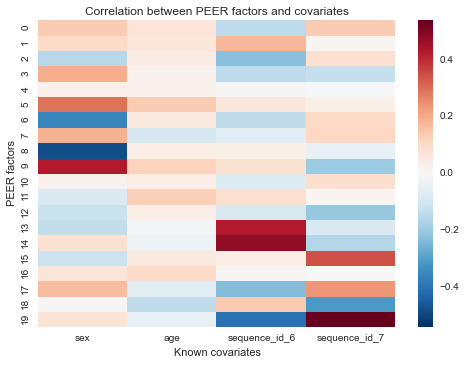

In [188]:
t = sns.heatmap(c_corrs)
plt.xlabel('Known covariates')
plt.ylabel('PEER factors')
plt.title('Correlation between PEER factors and covariates')
plt.savefig(os.path.join(outdir, 'peer_cov_corr.pdf'))

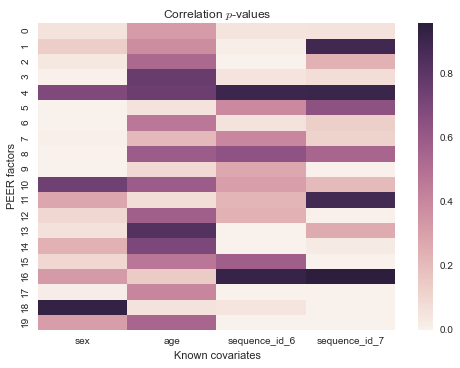

In [189]:
sns.heatmap(c_pvals)
plt.xlabel('Known covariates')
plt.ylabel('PEER factors')
plt.title('Correlation $p$-values');

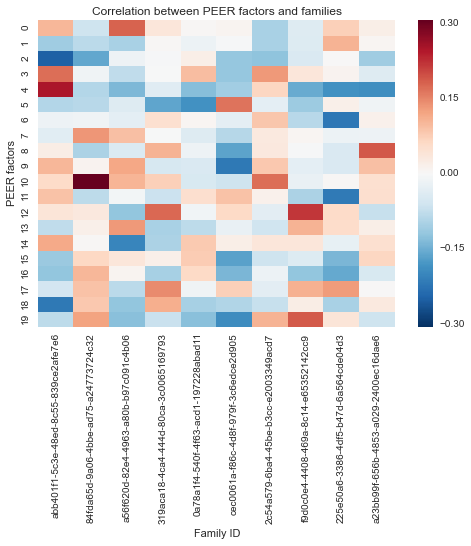

In [190]:
sns.heatmap(f_corrs)
plt.xlabel('Family ID')
plt.ylabel('PEER factors')
plt.title('Correlation between PEER factors and families')
plt.savefig(os.path.join(outdir, 'peer_fam_corr.pdf'))

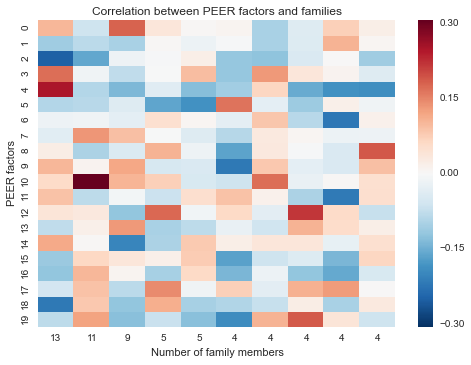

In [193]:
t = copy.deepcopy(f_corrs)
t.columns = subject_meta.family_id.value_counts()[t.columns]
sns.heatmap(t)
plt.xlabel('Number of family members')
plt.ylabel('PEER factors')
plt.title('Correlation between PEER factors and families')
plt.savefig(os.path.join(outdir, 'peer_fam_corr_num.pdf'))

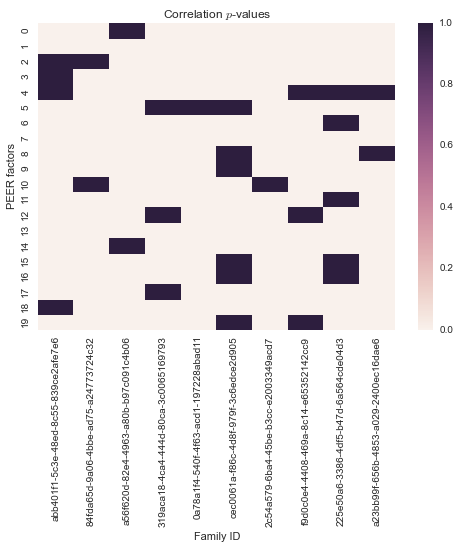

In [192]:
sns.heatmap(f_pvals < 0.05)
plt.xlabel('Family ID')
plt.ylabel('PEER factors')
plt.title('Correlation $p$-values');

In [ ]:
fns = [os.path.join(outdir, 'peer_10_factors.tsv'),
       os.path.join(outdir, 'peer_10_weights.tsv'),
       os.path.join(outdir, 'peer_10_precision.tsv'),
       os.path.join(outdir, 'peer_10_residuals.tsv'),
       os.path.join(outdir, 'tpm_log_filtered_phe_std_norm_peer_resid.tsv')]
if sum([os.path.exists(x) for x in fns]) != len(fns):
    model_10 = peer.PEER()
    model_10.setPhenoMean(tpm_f_std_norm)
    model_10.setNk(10)
    model_10.update()

    factors_10 = pd.DataFrame(model_10.getX(), index=tpm_f_std_norm.index)
    factors_10.to_csv(os.path.join(outdir, 'peer_10_factors.tsv'), 
                      sep='\t',header=False)
    weights_10 = pd.DataFrame(model_10.getW(), index=tpm_f_std_norm.columns)
    weights_10.to_csv(os.path.join(outdir, 'peer_10_weights.tsv'), 
                      sep='\t', header=False)
    precision_10 = pd.Series(model_10.getAlpha()[:, 0])
    precision_10.to_csv(os.path.join(outdir, 'peer_10_precision.tsv'), 
                        sep='\t', index=False, header=False)
    residuals_10 = pd.DataFrame(model_10.getResiduals(), index=tpm_f_std_norm.index,
                                columns=tpm_f_std_norm.columns)
    residuals_10.to_csv(os.path.join(outdir, 'peer_10_residuals.tsv'),
                        sep='\t')
    
    residuals_std_norm = transform_standard_normal(residuals_10)
    residuals_std_norm.to_csv(
        os.path.join(outdir, 'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), sep='\t')
else:
    factors_10 = pd.read_table(os.path.join(outdir, 'peer_10_factors.tsv'),
                               index_col=0, header=None)
    weights_10 = pd.read_table(os.path.join(outdir, 'peer_10_weights.tsv'),
                               index_col=0, header=None)
    precision_10 = pd.read_table(os.path.join(outdir, 'peer_10_precision.tsv'),
                                 header=None, squeeze=True)
    residuals_10 = pd.read_table(os.path.join(outdir, 'peer_10_residuals.tsv'),
                                 index_col=0)

#### FPKM

## Variant Regions

I'm going to identify the regions within 1 megabase of the TSSs for each gene whose
variants I want to test.

In [ ]:
fn = os.path.join(outdir, 'variant_regions.bed')
if not os.path.exists(fn):
    variant_regions = cpb.gencode.make_promoter_bed(cpy.gencode_gtf, merge_by_gene=True,
                                                    up=1000000, down=1000000, out=fn)
else:
    variant_regions = pbt.BedTool(fn)

In principle, there could be multiple regions per gene if a gene has TSSs located more than
1MB apart. In practice, this doesn't seem to happen.

In [ ]:
fn = os.path.join(outdir, 'gene_to_regions.p')
if not os.path.exists(fn):
    gene_to_regions = dict()
    for r in variant_regions:
        gene = r.name.split('_')[0]
        gene_to_regions[gene] = gene_to_regions.get(gene, []) + ['{}:{}-{}'.format(
                r.chrom, r.start, r.end)]
    fn = os.path.join(outdir, 'gene_to_regions.p')
    cPickle.dump(gene_to_regions, open(fn, 'wb') )

## SNV Filtering

I want to filter sites that are out of HWE. I'll choose the Europeans who either aren't in families
or one European from each family. 

In [137]:
subject_meta.estimated_ethnicity.value_counts()

EUR    150
EAS     32
AMR      7
AFR      3
SAS      3
dtype: int64

In [138]:
tdf = subject_meta[subject_meta.estimated_ethnicity == 'EUR']
a = tdf[tdf.family_id.isnull()]
b = tdf.dropna(subset=['family_id'])
b = b.drop_duplicates(subset=['family_id'])
tdf = pd.concat([a, b])
print('Number to use for HWE: {}'.format(tdf.shape[0]))

Number to use for HWE: 87


In [ ]:
fn = os.path.join(private_outdir, 'filtered.vcf.gz')
if not os.path.exists(fn):
    v = os.path.join(ciepy.root, 'private_data', 'wgs',
                     'biallelic_snvs.vcf.gz')
    samples = wgs_meta[wgs_meta.subject_id.apply(lambda x: x in tdf.index)].index
    c = ('{} --gzvcf {} --indv {} --hwe 0.000001 --max-missing 0.05 --recode --stdout '
         '| bgzip > {}'.format(
        cpy.vcftools, v, ' --indv '.join(samples), fn))
    subprocess.check_call(c, shell=True)
    shutil.move('out.log', os.path.join(private_outdir, 'hwe_filtering.log'))
    c = ('{} index {}'.format(cpy.bcftools, fn))
    subprocess.check_call(c, shell=True)

In [ ]:
fn = os.path.join(private_outdir, 'filtered_all', '0000.vcf.gz')
if not os.path.exists(fn)
    filtered_vcf = os.path.join(private_outdir, 'filtered.vcf.gz')
    all_vcf = os.path.join(ciepy.root, 'private_data', 'wgs',
                           'biallelic_snvs.vcf.gz')
    out = os.path.join(private_outdir, 'filtered_all')
    c = ('{} isec -O z -p {} -n=2 -w1 {} {}'.format(
        cpy.bcftools, out, all_vcf, filtered_vcf))
    subprocess.check_call(c, shell=True)
    c = ('{} index {}'.format(cpy.bcftools, fn))
    subprocess.check_call(c, shell=True)
    c = ('{} index -t {}'.format(cpy.bcftools, fn))
    subprocess.check_call(c, shell=True)